In [25]:
TRANING_DATA_FILE_PATH = './data_while_controlling_motor/220315/220315_kurimoto_2.txt'
TOTAL_TRAINING_TIME = 30
MULTIPLIER_FOR_CONVERTING_TORQUE_TO_FORCE = 4
MULTIPLIER_FOR_CONVERTING_RAD_TO_CM = - 0.025 * 100  # [cm/rad] l=rΘ なのでl/Θ=r
INITIAL_WEIGHT = 10 # [kg]

In [26]:
import re
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [27]:
def extract_texts(input_path, re_keyword):
    """
    テキストファイルの中から、正規表現で与えられたキーワードに合致する部分を全て抽出し、リストに格納して返す

    Params
    ----
    input_path: テキストファイルのファイルパス
    re_keyword: 合致するか調べるキーワード(正規表現)

    Return
    -----
    list_of_texts_matching_re_keyword: re_keywordに合致する部分を全て抽出して格納したリスト
    """

    #　ファイルからテキストを読み込む
    with open(input_path, "r") as f:
        input_text = f.read()

    # 正規表現で与えられたキーワードに合致するテキストを抽出し格納したリスト
    list_of_texts_matching_re_keyword = re.findall(re_keyword, input_text)

    return list_of_texts_matching_re_keyword


def extract_nums_after_keyword(input_path, re_keyword):
    """
    テキストファイルの中から、正規表現で与えられたキーワードの直後に並ぶ数値を取り出し、リストに格納する

    Params
    ----
    input_path: テキストファイルのファイルパス
    re_keyword: 合致するか調べるキーワード(正規表現)

    Return
    -----
    nums_after_keyword: re_keywordの直後に並ぶ数値を取り出して格納したリスト
    """

    #　ファイルからテキストを読み込む
    with open(input_path, "r") as f:
        input_text = f.read()

    re_keyword_with_nums = re_keyword + "[+-]?\d+(?:\.\d+)?" # 数値込みの検索キーワードを生成
    list_of_texts_matching_re_keyword_with_nums = re.findall(re_keyword_with_nums, input_text) # 数値込みの検索キーワードに合致する部分を抽出してリストに格納
    text_matching_re_keyword_with_nums = ''.join(list_of_texts_matching_re_keyword_with_nums) # 数値込みの検索キーワードに合致する部分を、一つのテキストに結合する

    nums_after_keyword_str = re.findall("[+-]?\d+(?:\.\d+)?", text_matching_re_keyword_with_nums) # 数値のみ抽出し格納したリスト
    nums_after_keyword = list(map(float, nums_after_keyword_str)) # 数値のみ抽出し格納したリストを数値に変換

    return nums_after_keyword


def plot_graph(data, total_time):
    """
    グラフを描画

    Params
    ------
    data: 描画する数字を格納したリスト
    total_time: データを取得していた合計時間
    """
    y = np.array(data)
    num_of_data = len(y) # データ数
    dt = total_time / num_of_data # 各データ間の(平均)時間変化 
    x = np.array([i * dt for i in range(0, num_of_data)]) # x軸に表示する秒数

    #描画
    plt.figure(figsize=(15,10))
    plt.plot(x, y)


def calculate_average(data, dt, start_time, end_time):
    """
    ある時刻からある時刻までに平均値を計算する

    Params
    ------
    data: 平均値を求めるデータ
    dt: 各データ間の時間
    start_time: 平均値を求める区間の最初の時刻
    end_time: 平均値を求める区間の最後の時刻

    Return
    ------
    average_of_data: 与えられた区間における、データの平均値
    """

    # 与えられた区間の先頭と最後が、配列dataにおいてそれぞれ何番目に当たるか調べる
    first_index = int(start_time / dt)
    end_index = int(end_time / dt)

    # 平均値をとる
    average_of_data = data[first_index:end_index].mean()

    return average_of_data

In [28]:
"""
負荷、スピード、位置、時間、出力のデータを、それぞれ配列の形で作成
"""

# 位置、トルク、負荷、スピードのデータを取得
position_received_data =  -np.array(extract_nums_after_keyword(TRANING_DATA_FILE_PATH, '\"rotationAngleFromInitialPosition\":')) # 位置データ。ウェイトの上下と符号を合わせたければ、符号反転させる
torque_received_data = np.array(extract_nums_after_keyword(TRANING_DATA_FILE_PATH, '{\"torque_received\":')) # トルクデータ
speed_received_data = np.array(extract_nums_after_keyword(TRANING_DATA_FILE_PATH, '\"speed_received\":')) # スピードデータ

# データの換算
force_received_data = torque_received_data * MULTIPLIER_FOR_CONVERTING_TORQUE_TO_FORCE + INITIAL_WEIGHT # 負荷データ
position_modified_data =  position_received_data * MULTIPLIER_FOR_CONVERTING_RAD_TO_CM # cmに換算後の位置データ
position_modified_data =  position_modified_data - min(position_modified_data)  # 最小値を0にする

# 最小データ数に全てのデータを合わせる
num_of_data = min(len(position_received_data), len(torque_received_data), len(speed_received_data)) # データ数
position_received_data = position_received_data[:num_of_data]
torque_received_data = torque_received_data[:num_of_data]
force_received_data = force_received_data[:num_of_data]
speed_received_data = speed_received_data[:num_of_data]
# position_modified_data = position_modified_data[:num_of_data]

#　時間データを作成
dt = TOTAL_TRAINING_TIME / num_of_data # 各データ間の(平均)時間変化 
time_data = np.array([i * dt for i in range(0, num_of_data)]) # 時間を刻んだデータ

# 出力(パワー)のデータを作成
power_data = []
for i in range(num_of_data):
    power_data.append(- torque_received_data[i] * speed_received_data[i])

In [29]:
min(len(position_received_data), len(torque_received_data), len(speed_received_data))

361

In [30]:
len(position_modified_data)

362

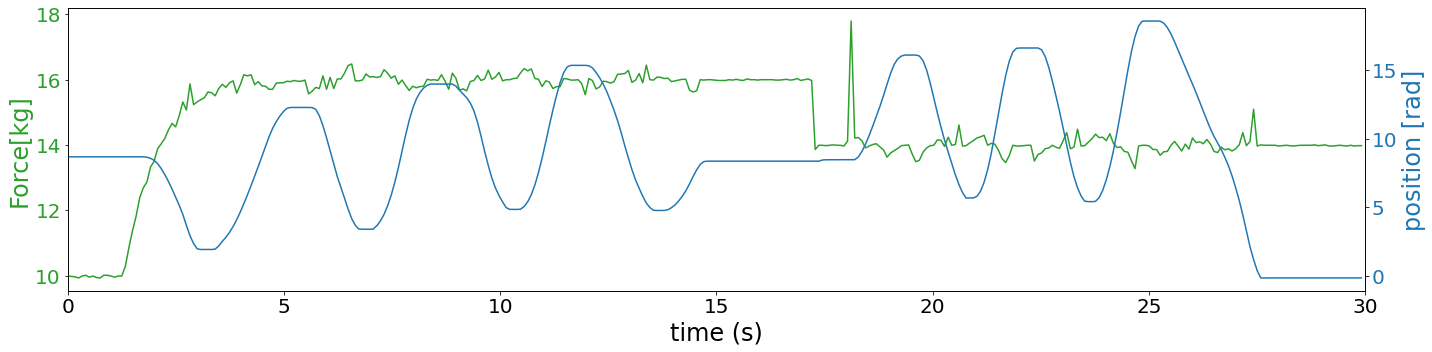

In [33]:
"""
位置と負荷と出力(パワー)のデータを描画
"""

fig, ax1 = plt.subplots(figsize=(20, 5))
"""
# 位置データを描画
color = 'tab:green'
ax1.set_ylabel('position [rad]', color=color, fontsize=24) 
ax1.plot(time_data, position_received_data, color=color)
ax1.tick_params(axis='y', labelcolor=color, labelsize=20)

# 負荷データを描画
ax2 = ax1.twinx()
color = 'tab:orange'
ax2.set_ylabel('force [kg]', color=color, fontsize=24)
ax2.plot(time_data, force_received_data, color=color)
ax2.tick_params(axis='y', labelcolor=color, labelsize=20)
"""
# 負荷データを描画
color = 'tab:green'
ax1.set_ylabel('Force[kg]', color=color, fontsize=24) 
ax1.plot(time_data, force_received_data,color=color)
ax1.tick_params(axis='y', labelcolor=color, labelsize=20)

# 位置データを描画
color = 'tab:blue'
ax2 = ax1.twinx()
ax2.set_ylabel('position [rad]', color=color, fontsize=24) 
ax2.plot(time_data, position_received_data, color=color)
ax2.tick_params(axis='y', labelcolor=color, labelsize=20)


# # 換算後位置データを描画
# ax2 = ax1.twinx()
# color = 'tab:orange'
# ax2.set_ylabel('position [cm]', color=color, fontsize=24)
# ax2.plot(time_data, position_modified_data, color=color)
# ax2.tick_params(axis='y', labelcolor=color, labelsize=20)

# # 速度データを描画
# ax3 = ax1.twinx()
# color = 'tab:blue'
# ax3.set_ylabel('speed [W]', color=color, fontsize=24) 
# ax3.plot(time_data, speed_received_data, color=color)
# ax3.tick_params(axis='y', labelcolor=color, labelsize=20)
# ax3.spines["right"].set_position(("axes", 1.2))

# 時間データを描画
ax1.set_xlabel('time (s)', fontsize=24)
ax1.tick_params(axis='x', labelsize=20)
ax1.set_xlim([5, 25])
ax2.set_xlim([4, 25])

fig.tight_layout()
plt.show()

In [32]:
"""
平均負荷と力積を計算・表示
"""

# 計算する区間の最初の時刻と最後の時刻を入力
START_TIME = 0
END_TIME = TOTAL_TRAINING_TIME

# 計算
average_force = calculate_average(force_received_data, dt, START_TIME, END_TIME)
impulse = average_force * (END_TIME - START_TIME)

# 表示
print("平均負荷は {} [kg]".format(average_force))
print("力積は {} [kg・s]".format(impulse))

平均負荷は 14.728630980609417 [kg]
力積は 441.8589294182825 [kg・s]
